In [163]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [164]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def epsilon_greedy_policy(q_network, state, epsilon, action_size):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = q_network(state_tensor)
            return q_values.argmax().item()

def deep_q_learning_vanilla(env=gym.make('CartPole-v1'), episodes=20000, max_steps=200, gamma=0.99, epsilon=1.0, learning_rate=0.001):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    q_network = QNetwork(state_size, action_size)
    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)

    rewards_per_episode = []
    epsilon_per_episode = []
    loss_per_episode = [0]

    best_reward = -float('inf')

    for episode in range(episodes):
        state = env.reset()[0]  # Initialize the environment and get the initial state
        total_reward = 0

        for step in range(max_steps):
            # Select action using epsilon-greedy policy
            action = epsilon_greedy_policy(q_network, state, epsilon, action_size)

            # Perform the action and observe the next state and reward
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            # Calculate the target Q-value
            with torch.no_grad():
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
                max_next_q = q_network(next_state_tensor).max().item()
                target = reward + gamma * max_next_q * (1 - done)

            # Update the Q-network
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_tensor = torch.tensor([action], dtype=torch.int64)
            q_values = q_network(state_tensor).gather(1, action_tensor.unsqueeze(-1)).squeeze(-1)
            loss = nn.MSELoss()(q_values, torch.tensor([target], dtype=torch.float32))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Transition to the next state
            state = next_state

            # Speichere den Loss für diese Episode
            if len(loss_per_episode) <= episode:
                loss_per_episode.append(0)  # Initialisiere Episode mit 0
                loss_per_episode[episode-1] += loss.item()

            # If the episode is done, break
            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon - 1 / episodes, 0)
        epsilon_per_episode.append(epsilon)

        rewards_per_episode.append(total_reward)

        if episode % 1000 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {total_reward}")

        if total_reward >= best_reward:
            best_reward = total_reward
            print(f'Best Reward so far: {best_reward}')
            #torch.save(q_network.state_dict(), f'DQN_CartPole_BestReward_{best_reward}.pt')

    return q_network, rewards_per_episode, epsilon_per_episode, loss_per_episode

def deep_q_learning_extansion(env=gym.make('CartPole-v1'), episodes=20000, max_steps=200, gamma=0.99, epsilon=1.0, memory_size=100000, batch_size=32, network_sync_rate=50000, learning_rate=0.001):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    q_network = QNetwork(state_size, action_size)
    target_network = QNetwork(state_size, action_size)
    target_network.load_state_dict(q_network.state_dict())
    target_network.eval()

    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    replay_buffer = deque(maxlen=memory_size)

    rewards_per_episode = []
    epsilon_per_episode = []
    loss_per_episode = [0]

    step_count = 0
    best_reward = -1000

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        for i in range(max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_network(state_tensor)).item()

            next_state, reward, done, _, _ = env.step(action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                minibatch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                q_values = q_network(states).gather(1, actions).squeeze(1)
                next_q_values = target_network(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                step_count += 1

                # Speichere den Loss für diese Episode
                if len(loss_per_episode) <= episode:
                    loss_per_episode.append(0)  # Initialisiere Episode mit 0
                    loss_per_episode[episode-1] += loss.item()

            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon - 1 / episodes, 0)
        epsilon_per_episode.append(epsilon)

        rewards_per_episode.append(total_reward)

        if episode % 1000 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {total_reward}")

        if total_reward > best_reward:
            best_reward = total_reward
            print(f'Best Reward so far: {best_reward}')
            #torch.save(q_network.state_dict(), f'DQN_CartPole_BestReward_{best_reward}.pt')

        if step_count > network_sync_rate:
            #print('Network syncing')
            target_network.load_state_dict(q_network.state_dict())
            step_count = 0

        if total_reward >= best_reward:
            best_reward = total_reward
            print(f'Best Reward so far: {best_reward}')
            torch.save(q_network.state_dict(), f'Gradients/DQN_CartPole_BestReward_{best_reward}.pt')

    return q_network, rewards_per_episode, epsilon_per_episode, loss_per_episode



In [184]:
def meanLists(epsilon_per_episode, rewards_per_episode, loss_per_episode):
    # Beispiel: Berechnung des gleitenden Durchschnitts für epsilon_per_episode
    window_size = 100
    smoothed_epsilon = [ np.mean(epsilon_per_episode[max(0, i - window_size):i + 1]) for i in range(len(epsilon_per_episode))]
    smoothed_reward = [np.mean(rewards_per_episode[max(0, i - window_size):i + 1]) for i in range(len(rewards_per_episode))]
    smoothed_loss = [np.mean(loss_per_episode[max(0, i - window_size):i + 1]) for i in range(len(loss_per_episode))]

    return smoothed_epsilon, smoothed_reward, smoothed_loss

def plot(epsilon_per_episode, rewards_per_episode, loss_per_episode):

    smoothed_epsilon, smoothed_reward, smoothed_loss = meanLists(epsilon_per_episode, rewards_per_episode, loss_per_episode)

    plt.figure(figsize=(10,10))
    steps = 100
    xs = np.linspace(0, episodes, int(episodes/steps)+1)

    plt.subplot(3, 1, 1)
    plt.plot(loss_per_episode, alpha=0.2, label="Loss per Episode")
    plt.plot(smoothed_loss, label="Average Loss per Episode")
    plt.xlabel("Training Iteration")
    plt.ylabel("Loss")
    plt.title("Loss During Training")
    plt.xticks(range(0, 10001, 1000))
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(rewards_per_episode, alpha=0.2, label="Reward per Episode")
    plt.plot(smoothed_reward, label="Average Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward (Return G)")
    plt.title("Cumulative Rewards per Episode")
    plt.xticks(range(0, 10001, 1000))
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epsilon_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.title("Epsilon Value per Episode")
    plt.xticks(range(0, 10001, 1000))

    # Show the plots
    plt.tight_layout()
    plt.show()

In [195]:
env = gym.make('CartPole-v1')
episodes = 10000
gamma = 0.99
epsilon = 1.0
max_steps = 200
learning_rate = 0.0001

network_sync_rate = 500
buffer_size = 100
batch_size = 32

In [179]:
q_network_1, rewards_per_episode_1, epsilon_per_episode_1, loss_per_episode_1 = deep_q_learning_vanilla(env, episodes, max_steps, gamma, epsilon, learning_rate)

Episode 0/10000, Total Reward: 30.0
Episode 1000/10000, Total Reward: 12.0
Episode 2000/10000, Total Reward: 16.0
Episode 3000/10000, Total Reward: 18.0
Episode 4000/10000, Total Reward: 132.0
Episode 5000/10000, Total Reward: 200.0
Episode 6000/10000, Total Reward: 200.0
Episode 7000/10000, Total Reward: 200.0
Episode 8000/10000, Total Reward: 200.0
Episode 9000/10000, Total Reward: 200.0


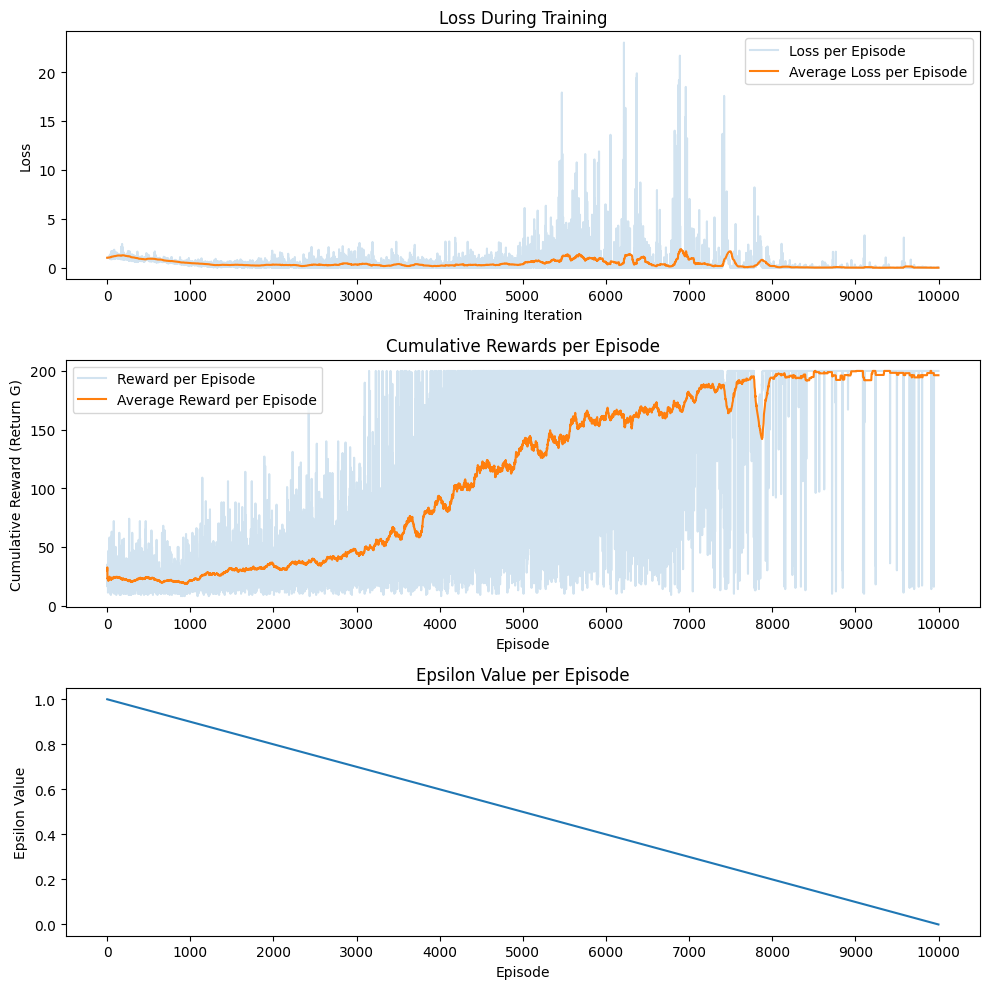

In [185]:
plot(epsilon_per_episode_1, rewards_per_episode_1, loss_per_episode_1)

**Reflection**
- Also um die beiden Agenten miteinander zu vergleichen könnte man die Agenten in Pygame laufen lassen und gucken welcher von den beiden besser abschneidet.

In [196]:
q_network, rewards_per_episode, epsilon_per_episode, loss_per_episode = deep_q_learning_extansion(env, episodes, max_steps, gamma, epsilon, buffer_size, batch_size, network_sync_rate, learning_rate)


Episode 0/10000, Total Reward: 11.0
Best Reward so far: 11.0
Best Reward so far: 13.0
Best Reward so far: 39.0
Best Reward so far: 47.0
Best Reward so far: 58.0
Best Reward so far: 78.0
Best Reward so far: 103.0
Best Reward so far: 116.0
Episode 1000/10000, Total Reward: 10.0
Best Reward so far: 130.0
Best Reward so far: 147.0
Episode 2000/10000, Total Reward: 43.0
Best Reward so far: 183.0
Best Reward so far: 200.0
Episode 3000/10000, Total Reward: 76.0
Episode 4000/10000, Total Reward: 21.0
Episode 5000/10000, Total Reward: 76.0
Episode 6000/10000, Total Reward: 81.0
Episode 7000/10000, Total Reward: 200.0
Episode 8000/10000, Total Reward: 125.0
Episode 9000/10000, Total Reward: 200.0


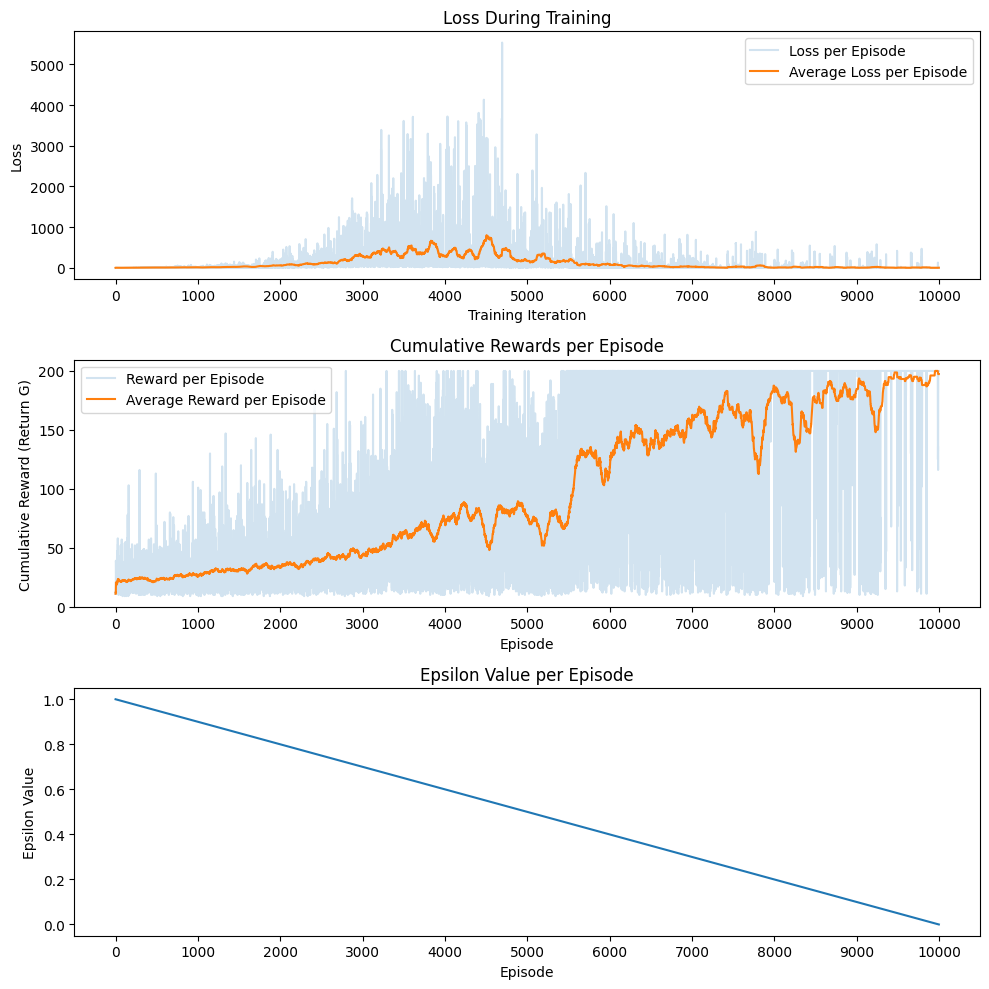

In [199]:
plot(epsilon_per_episode, rewards_per_episode, loss_per_episode)

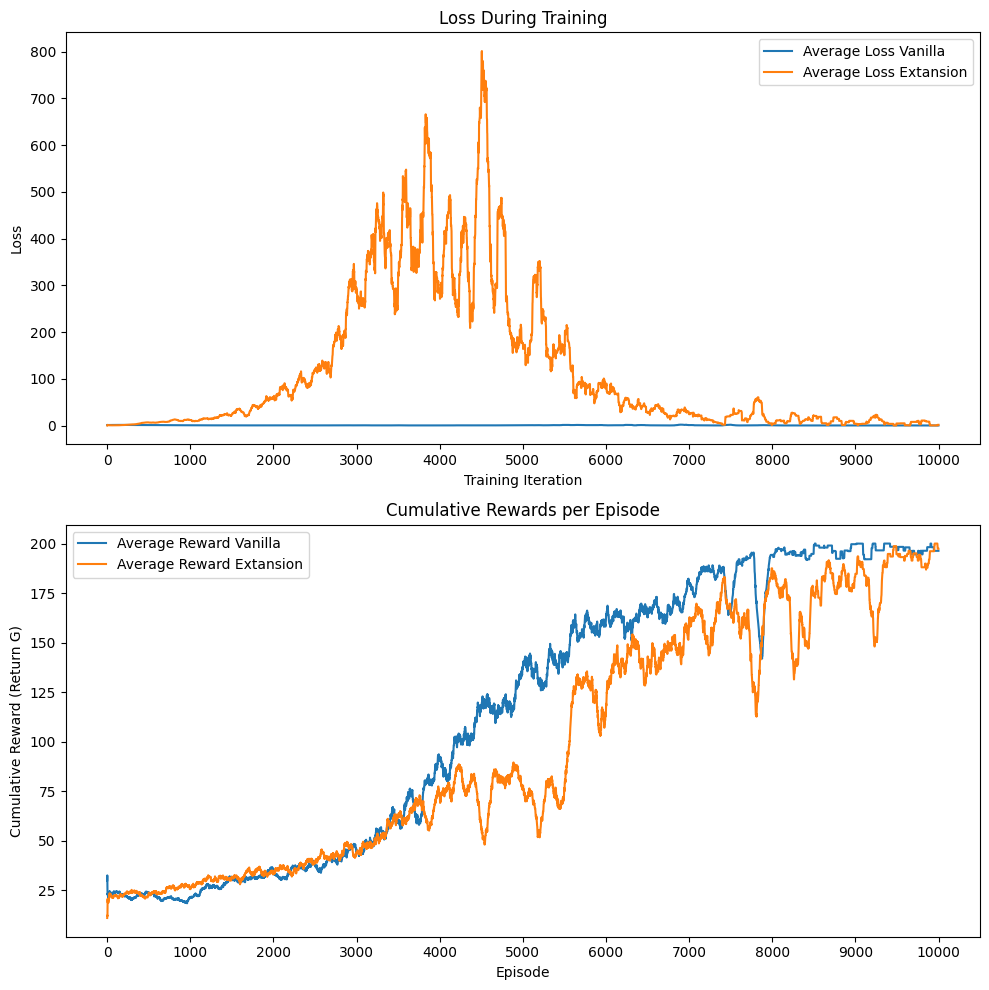

In [200]:
smoothed_epsilon, smoothed_reward, smoothed_loss = meanLists(epsilon_per_episode, rewards_per_episode, loss_per_episode)

smoothed_epsilon_vanilla, smoothed_reward_vanilla, smoothed_loss_vanilla= meanLists(epsilon_per_episode_1, rewards_per_episode_1, loss_per_episode_1)

plt.figure(figsize=(10,10))
steps = 100
xs = np.linspace(0, episodes, int(episodes/steps)+1)

plt.subplot(2, 1, 1)
plt.plot(smoothed_loss_vanilla, label="Average Loss Vanilla")
plt.plot(smoothed_loss, label="Average Loss Extansion")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.xticks(range(0, 10001, 1000))
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(smoothed_reward_vanilla, label="Average Reward Vanilla")
plt.plot(smoothed_reward, label="Average Reward Extansion")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward (Return G)")
plt.title("Cumulative Rewards per Episode")
plt.xticks(range(0, 10001, 1000))
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


**Reflection**

**Theoretisch**
1. Replay Buffer
- Replay Buffer speicherr die Transitions und nutzen diese für das Training. Denn werden N zufällige Tranisitions ausgewählt, mit denen dann trainiert wird. Dadurch können Korrelationen von aufeinanderfolgenden Übergängen vermieden werden, also dadruch wird der Alogrithmus stabiler, da overfitting vermieden werden kann.

2. Target Network
- Das Target Network kopiert alle C Schritte das Q Network. Dadurch findet eine stabilieren Q-Wert Schätzung statt, da das Target Network seltener aktualisiert wird und damit nicht so sehr schwankt, zudem kann dadurch auch die Gradienten berechnung stabilier werden.

**Unsere Ergebnisse**
 Der Algorithmus mit einem buffer und mit eine Target Network sollten eig besser seien, leider trifft das bei uns im Beispiel nicht zu. Das könnte mehrere Gründen haben:
    1. Der plausibelste Grund wäre, das etwas im Algorithmus nicht stimmt, also dass wir einen Implemtierungfehler haben.
    2. Der andere Grund könnte sein, dass die Buffer_größe und C, also nach vielen Episoden das Q network kopiert werden soll, falsch eingestellt sind und es dadurch zu einer schlechteren Modellleistung führt.